### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import joblib
import pickle
import os

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix, 
    classification_report
)
from sklearn.tree import plot_tree

### Import and Split Dataset

In [4]:
df = pd.read_csv('..\\data\\clean\\ordinal_encoded.csv')

X = df.drop('class_value', axis=1)
y = df['class_value']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

class_names = ['Unacceptable', 'Acceptable', 'Good', 'Very Good']
feature_names = X.columns.tolist()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

graph_directory = "..\\graphs\\"

### General Purpose Methods

In [5]:
# Define Hyperparameter Grids for Different Models
model_configs = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'param_grid': {
            'solver': ['lbfgs', 'liblinear'],
            'C': [0.1, 1, 10],
            'max_iter': [500, 1000, 1500]
        }
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'param_grid': {
            # Note: GaussianNB has very limited hyperparameters
            'var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    },
    'SVC': {
        'model': SVC(random_state=42),
        'param_grid': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'param_grid': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    }
}

In [8]:
def train_and_evaluate_model(
    model, 
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    model_name, 
    param_grid=None, 
    cv_splits=5, 
    feature_names=None,
    class_names=None,
    graph_directory='..\\graphs\\',
    do_hyperparameter_tuning=True,
    do_cross_validation=True
):
    # Prepare results dictionary
    results = {
        'original_model': model,
        'tuned_model': None,
        'training_time': None,
        'cv_scores': None,
        'metrics': {},
        'best_params': None
    }
    
    # Hyperparameter Tuning
    if param_grid and do_hyperparameter_tuning:
        # Setup stratified cross-validation
        cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
        
        # Perform Grid Search
        grid_search = GridSearchCV(
            estimator=model, 
            param_grid=param_grid, 
            cv=cv, 
            scoring='f1_macro', 
            n_jobs=-1
        )
        
        # Measure training time for tuned model
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        end_time = time.time()
        
        # Store results
        results['tuned_model'] = grid_search.best_estimator_
        results['training_time'] = end_time - start_time
        results['best_params'] = grid_search.best_params_
        
        # Use tuned model for further evaluation
        model_to_evaluate = grid_search.best_estimator_
    else:
        # Measure training time for original model
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        
        results['training_time'] = end_time - start_time
        model_to_evaluate = model
    
    # Cross-Validation
    if do_cross_validation:
        cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
        cv_scores = cross_val_score(
            model_to_evaluate, 
            X_train, 
            y_train, 
            cv=cv, 
            scoring='f1_macro'
        )
        results['cv_scores'] = {
            'mean': np.mean(cv_scores),
            'std': np.std(cv_scores),
            'individual_scores': cv_scores
        }
    
    # Predictions and Metrics
    y_pred = model_to_evaluate.predict(X_test)
    
    # Calculate performance metrics
    results['metrics'] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'f1_score': f1_score(y_test, y_pred, average='macro', zero_division=0)
    }
    
    # Print Performance Metrics
    print(f"\n{model_name} Model Performance:")
    for metric, value in results['metrics'].items():
        print(f"{metric.capitalize()}: {value:.4f}")
    
    # Detailed Classification Report
    print("\nDetailed Classification Report:")
    print(classification_report(
        y_test, y_pred, 
        target_names=class_names, 
        zero_division=0
    ))
    
    # Confusion Matrix Visualization
    plt.figure(figsize=(10, 7))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=class_names, 
        yticklabels=class_names
    )
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f"{graph_directory}confusion_matrices\\{model_name.lower()} confusion matrix")
    plt.show()
    
    # Feature Importance (for models that support it)
    if feature_names is not None:
        try:
            # Different models have different ways of accessing feature importance
            if hasattr(model_to_evaluate, 'coef_'):
                feature_importance = np.abs(model_to_evaluate.coef_[0])
            elif hasattr(model_to_evaluate, 'feature_importances_'):
                feature_importance = model_to_evaluate.feature_importances_
            else:
                feature_importance = None
            
            if feature_importance is not None:
                plt.figure(figsize=(10, 6))
                feature_importance_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': feature_importance
                }).sort_values('importance', ascending=False)
                
                sns.barplot(x='importance', y='feature', data=feature_importance_df)
                plt.title(f'{model_name} - Feature Importance')
                plt.xlabel('Importance')
                plt.ylabel('Features')
                plt.tight_layout()
                plt.savefig(f"{graph_directory}feature_importance\\{model_name.lower()} feature importance")
                plt.show()
        except Exception as e:
            print(f"Could not plot feature importance: {e}")
    
    return results

#### Model Evaluation Function

In [9]:
def evaluate_model(model, X_test, y_test, model_name):
    output = f"{model_name.lower()} confusion matrix"
    directory = "confusion_matrices\\"

    # Predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Add zero_division parameter to handle classes with no predictions
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # Print performance metrics
    print(f"\n{model_name} Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"F1 Score (Macro): {f1:.4f}")
    
    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
    
    # Confusion Matrix Visualization
    plt.figure(figsize=(10,7))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=class_names, 
        yticklabels=class_names
    )
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(graph_directory + directory + output)
    plt.show()
    
    # Return both metrics and the model
    return {
        'metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        },
        'model': model
    }

#### Feature Importance Graph Function

In [10]:
def plot_feature_importance(model, feature_names, model_name):
    output = f"{model_name.lower()} feature importance"
    directory = "feature_importance\\"
    plt.figure(figsize=(12,6))
    
    # Different importance extraction for different model types
    if isinstance(model, LogisticRegression):
        importances = np.abs(model.coef_).mean(axis=0) # For Logistic Regression, use absolute coefficient values
    elif isinstance(model, DecisionTreeClassifier):
        importances = model.feature_importances_       # For Decision Tree, use built-in feature importance
    elif isinstance(model, RandomForestClassifier):
        importances = model.feature_importances_       # For Random Forest, use built-in feature importance
    else:
        print(f"Feature importance not supported for {model_name}")
        return
    
    # Create feature importance plot
    indices = np.argsort(importances)
    plt.title(f'{model_name} - Feature Importances')
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig(graph_directory + directory + output)
    plt.show()

#### Save Model Function

In [11]:
def save_model(model, model_name, save_formats=['joblib', 'pickle']):
    os.makedirs(f'..\\models\\{model_name}', exist_ok=True)

    # Save in specified formats
    if 'joblib' in save_formats:
        joblib_path = f'..\\models\\{model_name}\\{model_name}_model.joblib'
        joblib.dump(model, joblib_path)
        print(f"Model saved as Joblib: {joblib_path}")
    
    if 'pickle' in save_formats:
        pickle_path = f'..\\models\\{model_name}\\{model_name}_model.pkl'
        with open(pickle_path, 'wb') as f:
            pickle.dump(model, f)
        print(f"Model saved as Pickle: {pickle_path}")

## Logistic Regression


Logistic Regression Model Performance:
Accuracy: 0.8353
Precision: 0.7121
Recall: 0.6527
F1_score: 0.6774

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.72      0.53      0.61        77
  Acceptable       0.58      0.50      0.54        14
        Good       0.88      0.96      0.92       242
   Very Good       0.67      0.62      0.64        13

    accuracy                           0.84       346
   macro avg       0.71      0.65      0.68       346
weighted avg       0.82      0.84      0.82       346



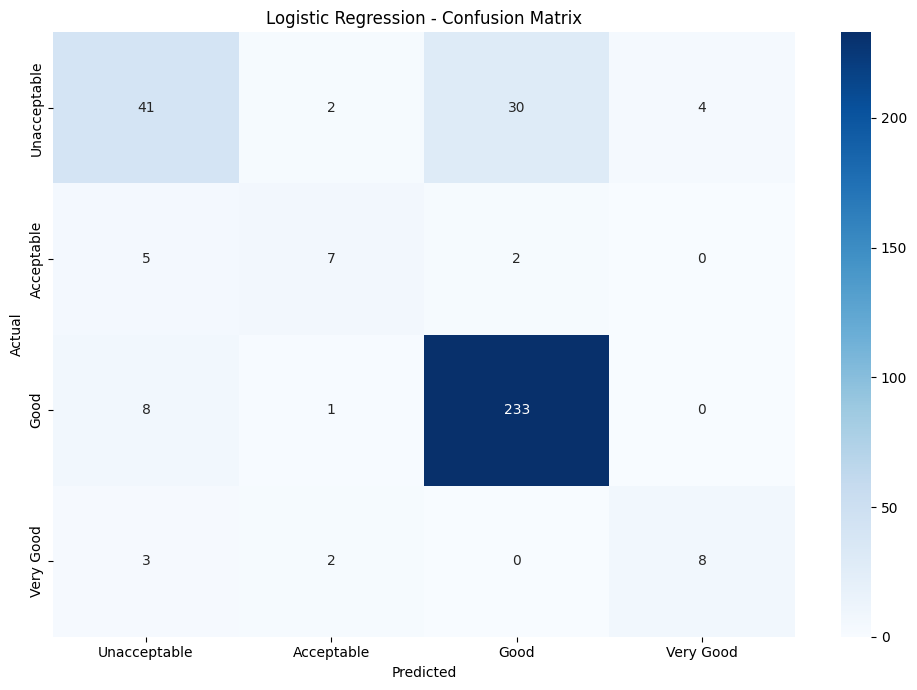

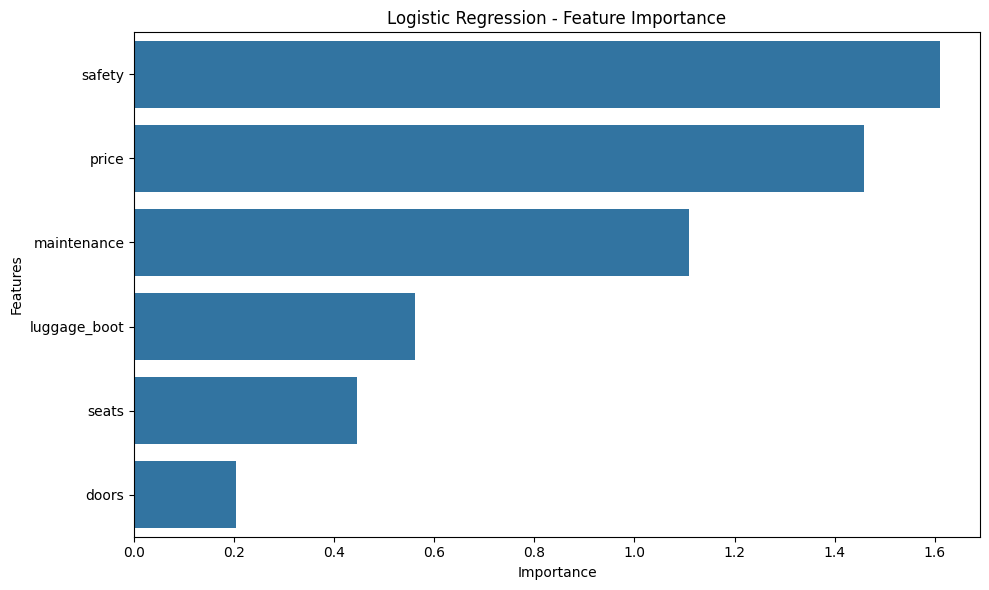

In [12]:
# Train Logistic Regression Model
lr_model = LogisticRegression(
    max_iter=1000
)

lr_results = train_and_evaluate_model(
    model=lr_model,
    X_train=X_train_scaled, 
    X_test=X_test_scaled, 
    y_train=y_train, 
    y_test=y_test,
    model_name='Logistic Regression',
    param_grid=model_configs['Logistic Regression']['param_grid'],
    feature_names=feature_names,
    class_names=class_names
)

# # Measure training time
# start_time = time.time()
# lr_model.fit(X_train_scaled, y_train)
# end_time = time.time()

# # Calculate training duration
# lr_training_duration = end_time - start_time
# print(f"\nTraining Time for Support Vector Classifier: {lr_training_duration:.4f} seconds\n")

# # Evaluate Logistic Regression
# print("Logistic Regression Analysis:")
# lr_metrics = evaluate_model(lr_model, X_test_scaled, y_test, 'Logistic Regression')

# # Plot Logistic Regression Feature Importance
# plot_feature_importance(lr_model, feature_names, 'Logistic Regression')

# save_model(lr_model, "logistic_regression")

## Decision Tree


Decision Tree Model Performance:
Accuracy: 0.9913
Precision: 0.9655
Recall: 0.9925
F1_score: 0.9779

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.99      0.97      0.98        77
  Acceptable       0.88      1.00      0.93        14
        Good       1.00      1.00      1.00       242
   Very Good       1.00      1.00      1.00        13

    accuracy                           0.99       346
   macro avg       0.97      0.99      0.98       346
weighted avg       0.99      0.99      0.99       346



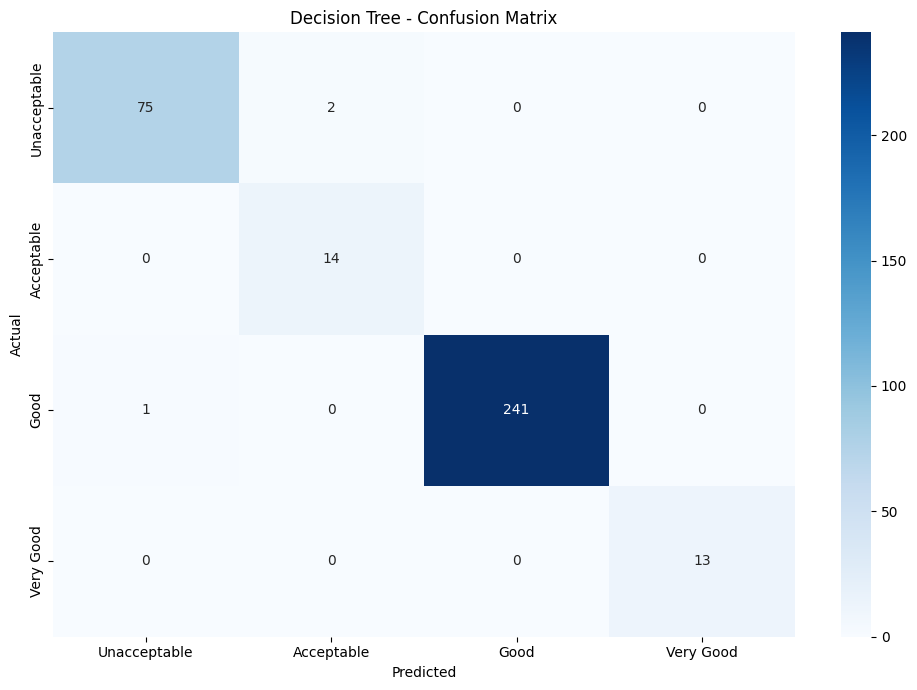

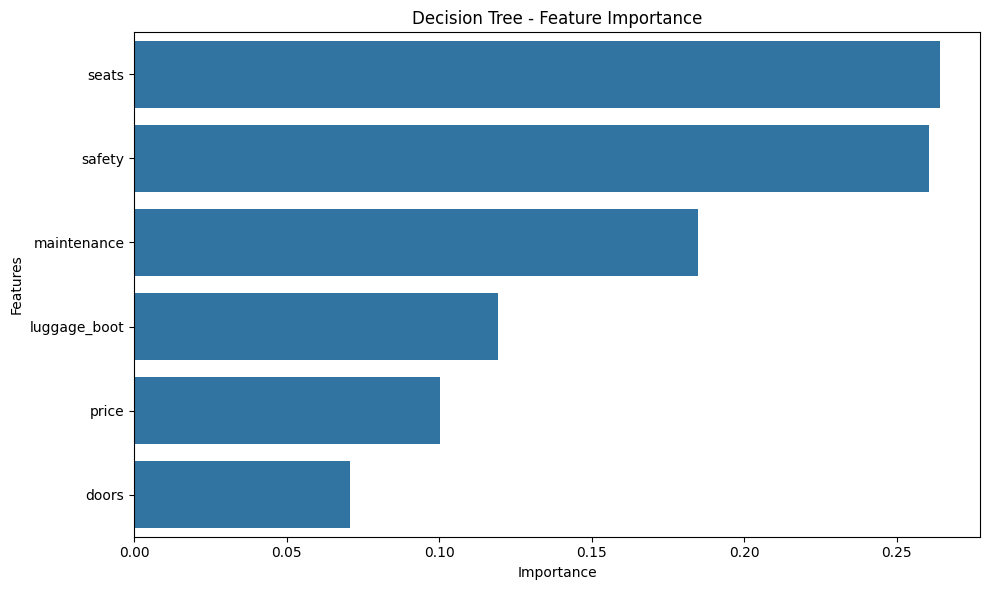

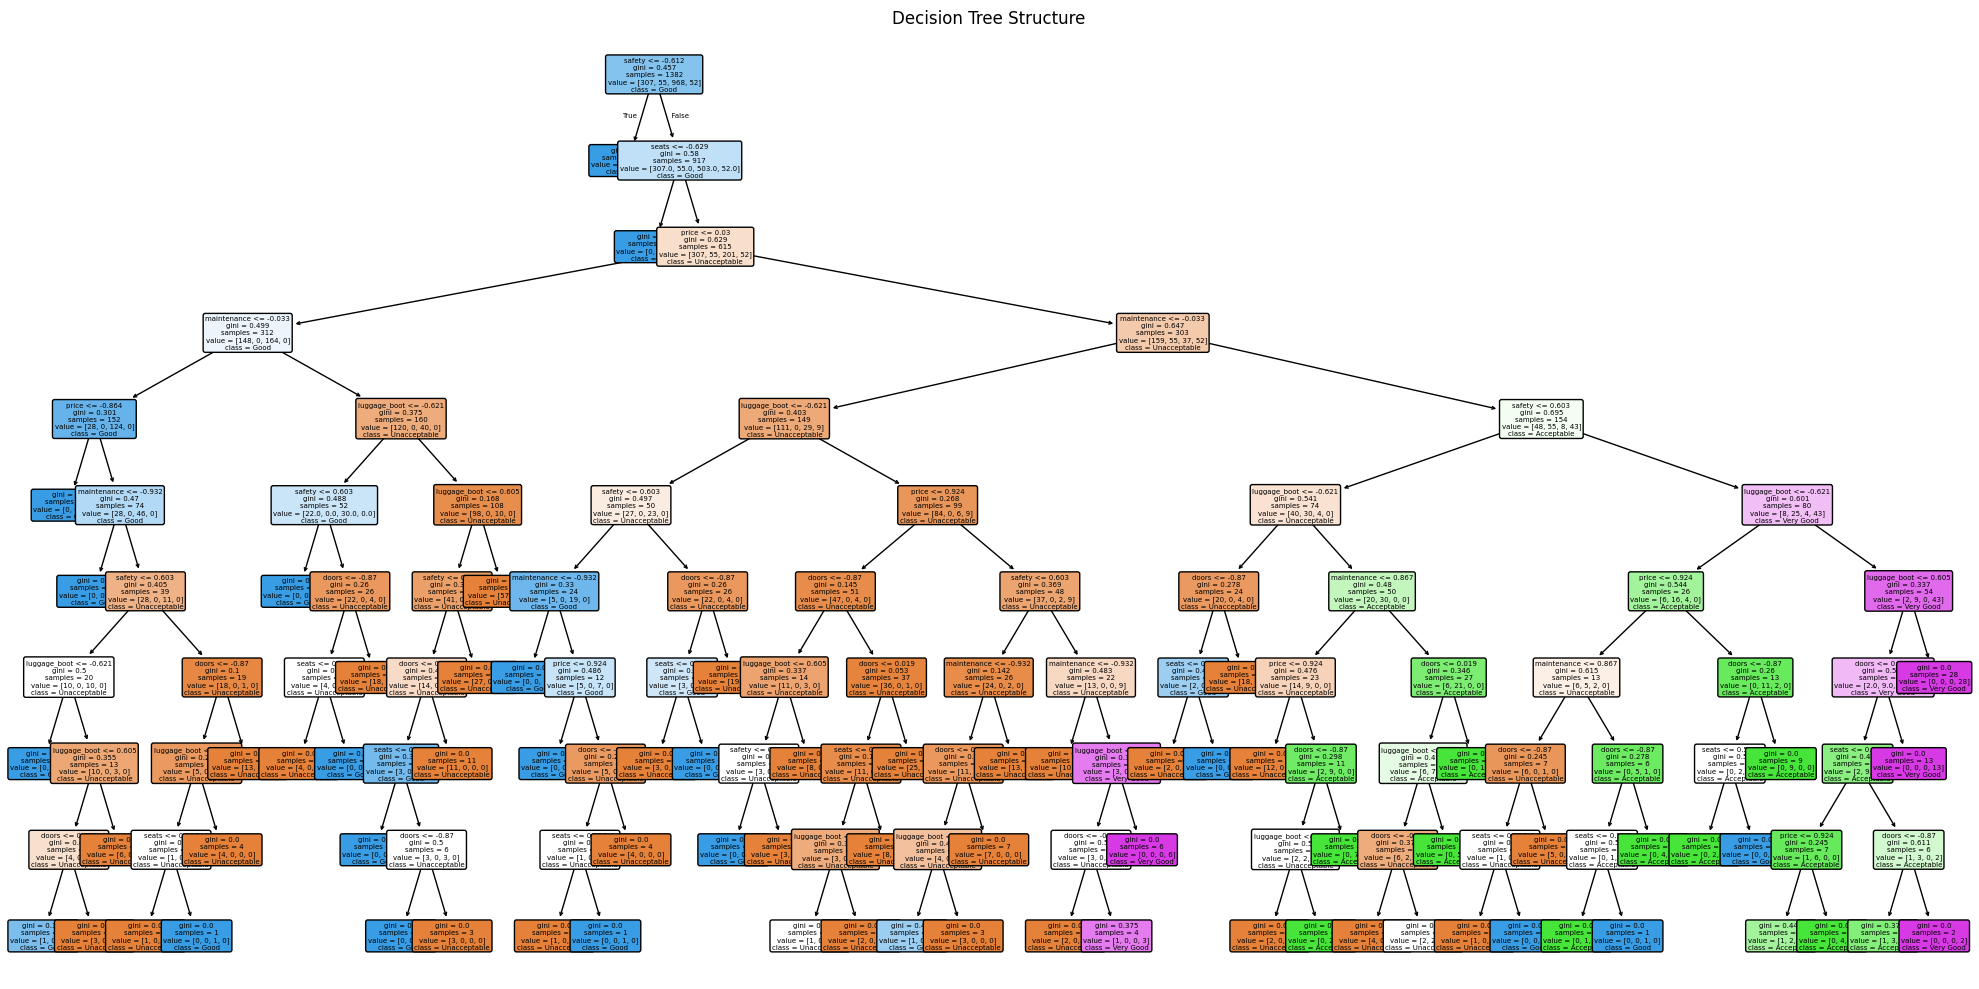

In [22]:
# Train Decision Tree Model
dt_model = DecisionTreeClassifier(
    random_state=42, 
)

dt_results = train_and_evaluate_model(
    model=dt_model,
    X_train=X_train_scaled, 
    X_test=X_test_scaled, 
    y_train=y_train, 
    y_test=y_test,
    model_name='Decision Tree',
    param_grid=model_configs['Decision Tree']['param_grid'],
    feature_names=feature_names,
    class_names=class_names   
)

# # Measure training time
# start_time = time.time()
# dt_model.fit(X_train, y_train)
# end_time = time.time()

# # Calculate training duration
# dt_training_duration = end_time - start_time
# print(f"\nTraining Time for Support Vector Classifier: {dt_training_duration:.4f} seconds")

# # Evaluate Decision Tree
# print("\nDecision Tree Analysis:")
# dt_metrics = evaluate_model(dt_model, X_test, y_test, 'Decision Tree')

# # Plot Decision Tree Feature Importance
# plot_feature_importance(dt_model, feature_names, 'Decision Tree')

directory = "\\other\\"
# Visualize Decision Tree Structure
plt.figure(figsize=(20,10))
plot_tree(
    dt_results['tuned_model'], 
    feature_names=feature_names, 
    class_names=class_names, 
    filled=True, 
    rounded=True,
    fontsize=5
)
plt.title('Decision Tree Structure')
plt.tight_layout()
plt.savefig(graph_directory + directory + "decision tree structure graph")
plt.show()

# save_model(dt_model, "decision_tree")

## Random Forest


Random Forest Model Performance:
Accuracy: 0.9884
Precision: 0.9740
Recall: 0.9413
F1_score: 0.9535

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.96      1.00      0.98        77
  Acceptable       0.93      1.00      0.97        14
        Good       1.00      1.00      1.00       242
   Very Good       1.00      0.77      0.87        13

    accuracy                           0.99       346
   macro avg       0.97      0.94      0.95       346
weighted avg       0.99      0.99      0.99       346



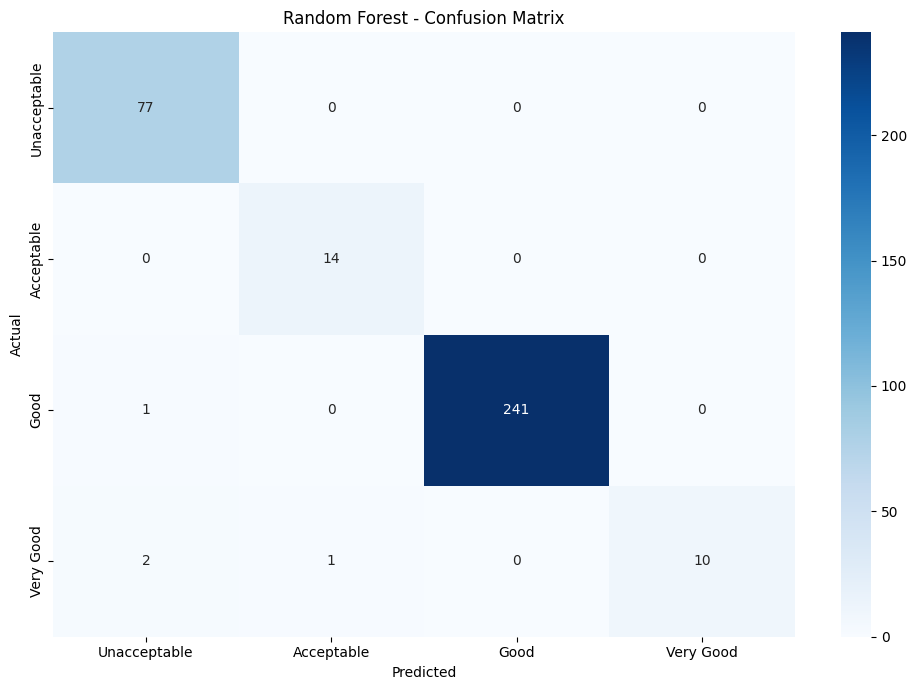

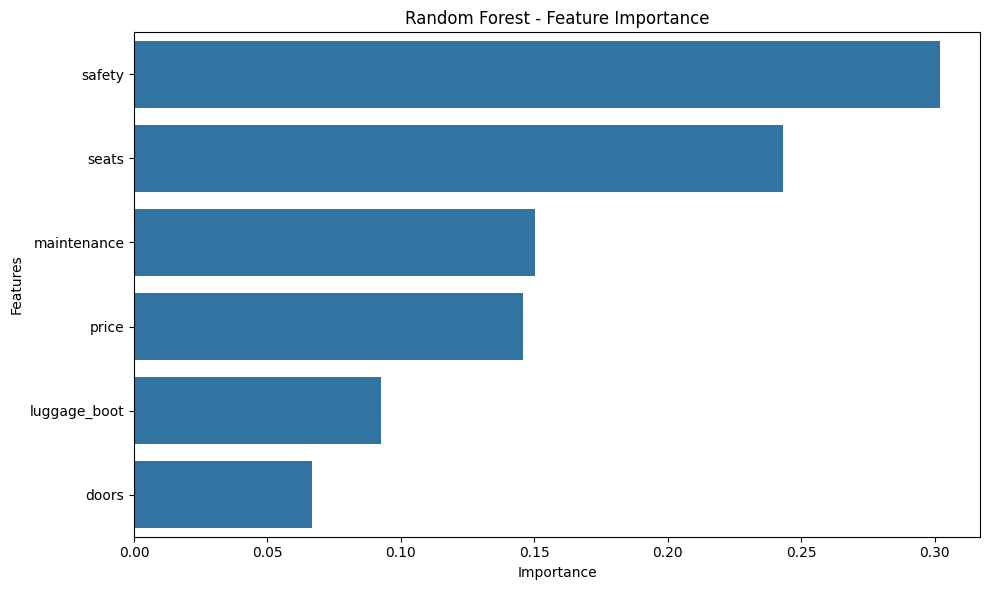

In [23]:
# Train Random Forest Model
rf_model = RandomForestClassifier(
    random_state=42,   # For reproducibility
    n_jobs=-1          # Use all available cores
)

rf_results = train_and_evaluate_model(
    model=rf_model,
    X_train=X_train_scaled, 
    X_test=X_test_scaled, 
    y_train=y_train, 
    y_test=y_test,
    model_name='Random Forest',
    param_grid=model_configs['Random Forest']['param_grid'],
    feature_names=feature_names,
    class_names=class_names
)

# # Measure training time
# start_time = time.time()
# rf_model.fit(X_train_scaled, y_train)
# end_time = time.time()

# # Calculate training duration
# rf_training_duration = end_time - start_time
# print(f"\nTraining Time for Support Vector Classifier: {rf_training_duration:.4f} seconds")

# # Evaluate Random Forest
# print("Random Forest Analysis:")
# rf_metrics = evaluate_model(rf_model, X_test_scaled, y_test, 'Random Forest')

# # Plot Random Forest Feature Importance
# plot_feature_importance(rf_model, feature_names, 'Random Forest')

# save_model(rf_model, "random_forest")



## Naive Bayes

In [268]:
def plot_naive_bayes_feature_importance(model, X, y, feature_names, model_name):
    output = "naive bayes feature importance"
    directory = "\\feature_importance\\"
    # Get unique classes
    classes = np.unique(y)
    
    # Calculate feature importance
    importances = np.zeros(X.shape[1])
    
    for feature_idx in range(X.shape[1]):
        # Extract feature column
        feature_column = X[:, feature_idx]
        
        # Compute class-wise differences
        class_means = []
        for cls in classes:
            class_samples = feature_column[y == cls]
            class_means.append(np.mean(class_samples))
        
        # Compute importance as max difference between class means
        max_diff = max(abs(class_means[i] - class_means[j]) 
                       for i in range(len(class_means)) 
                       for j in range(i+1, len(class_means)))
        
        importances[feature_idx] = max_diff
    
    # Plot feature importances
    plt.figure(figsize=(12,6))
    indices = np.argsort(importances)
    plt.title(f'{model_name} - Feature Discriminative Power')
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Discriminative Power')
    plt.tight_layout()
    plt.savefig(graph_directory + directory + output)
    plt.show()

    return importances


Training Time for Support Vector Classifier: 0.0010 seconds
Naive Bayes Analysis:

Naive Bayes Model Performance:
Accuracy: 0.7023
Precision (Macro): 0.5515
Recall (Macro): 0.5691
F1 Score (Macro): 0.4377

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.74      0.18      0.29        77
  Acceptable       0.43      0.21      0.29        14
        Good       0.86      0.88      0.87       242
   Very Good       0.18      1.00      0.30        13

    accuracy                           0.70       346
   macro avg       0.55      0.57      0.44       346
weighted avg       0.79      0.70      0.70       346



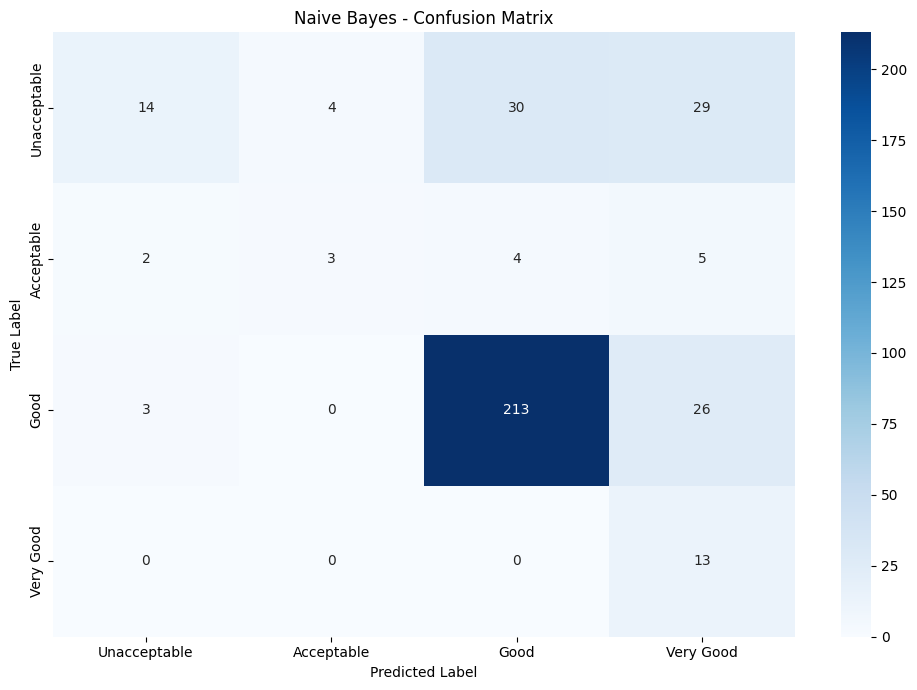

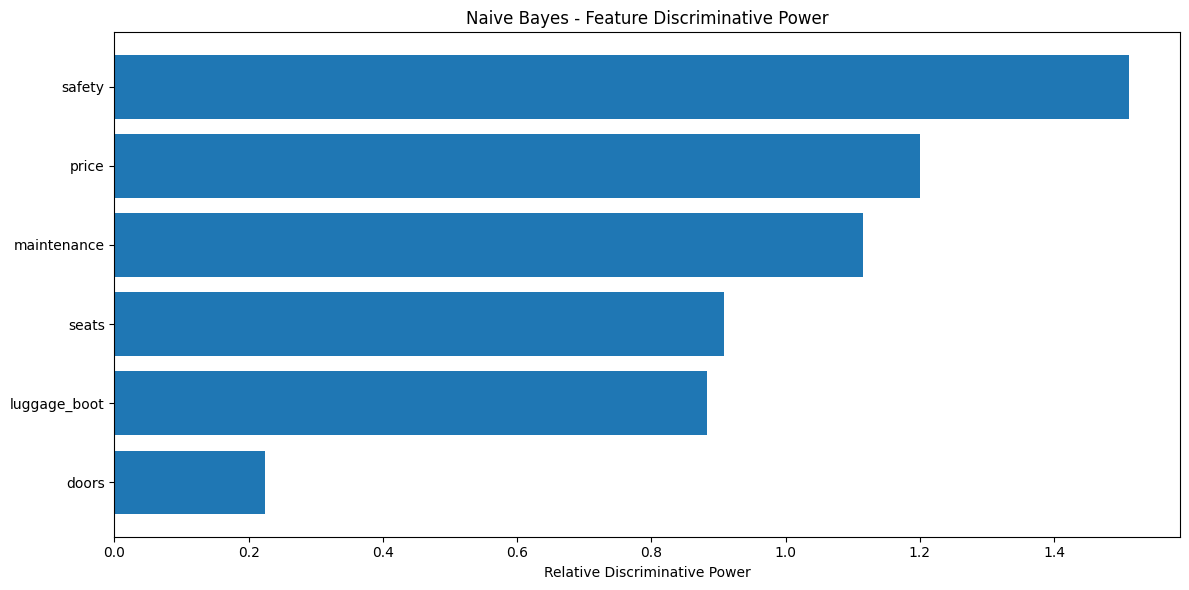

Model saved as Joblib: ..\models\naive_bayes\naive_bayes_model.joblib
Model saved as Pickle: ..\models\naive_bayes\naive_bayes_model.pkl


In [269]:
# Train Naive Bayes Model
nb_model = GaussianNB()

# Measure training time
start_time = time.time()
nb_model.fit(X_train_scaled, y_train)
end_time = time.time()

# Calculate training duration
nb_training_duration = end_time - start_time
print(f"\nTraining Time for Support Vector Classifier: {nb_training_duration:.4f} seconds")

# Evaluate Naive Bayes
print("Naive Bayes Analysis:")
nb_metrics = evaluate_model(nb_model, X_test_scaled, y_test, 'Naive Bayes')

# Plot Naive Bayes Feature Importance
plot_naive_bayes_feature_importance(
    nb_model, 
    X_train_scaled, 
    y_train, 
    feature_names, 
    'Naive Bayes'
)

save_model(nb_model, "naive_bayes")

## KNN

In [270]:
def plot_knn_feature_importance(X_train, y_train, feature_names, model_name):
    output = "knn feature importance"
    directory = "\\feature_importance\\"

    
    # Use mutual information to estimate feature importance
    from sklearn.feature_selection import mutual_info_classif
    
    # Calculate mutual information between features and target
    importances = mutual_info_classif(X_train, y_train)
    
    # Plot feature importances
    plt.figure(figsize=(12,6))
    indices = np.argsort(importances)
    plt.title(f'{model_name} - Feature Importance')
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Mutual Information Score')
    plt.tight_layout()
    plt.savefig(graph_directory + directory + output)
    plt.show()

    return importances


Training Time for Support Vector Classifier: 0.0053 seconds
K-Nearest Neighbors Analysis:

K-Nearest Neighbors Model Performance:
Accuracy: 0.9538
Precision (Macro): 0.9370
Recall (Macro): 0.8191
F1 Score (Macro): 0.8653

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.88      0.95      0.91        77
  Acceptable       0.89      0.57      0.70        14
        Good       0.98      0.99      0.98       242
   Very Good       1.00      0.77      0.87        13

    accuracy                           0.95       346
   macro avg       0.94      0.82      0.87       346
weighted avg       0.95      0.95      0.95       346



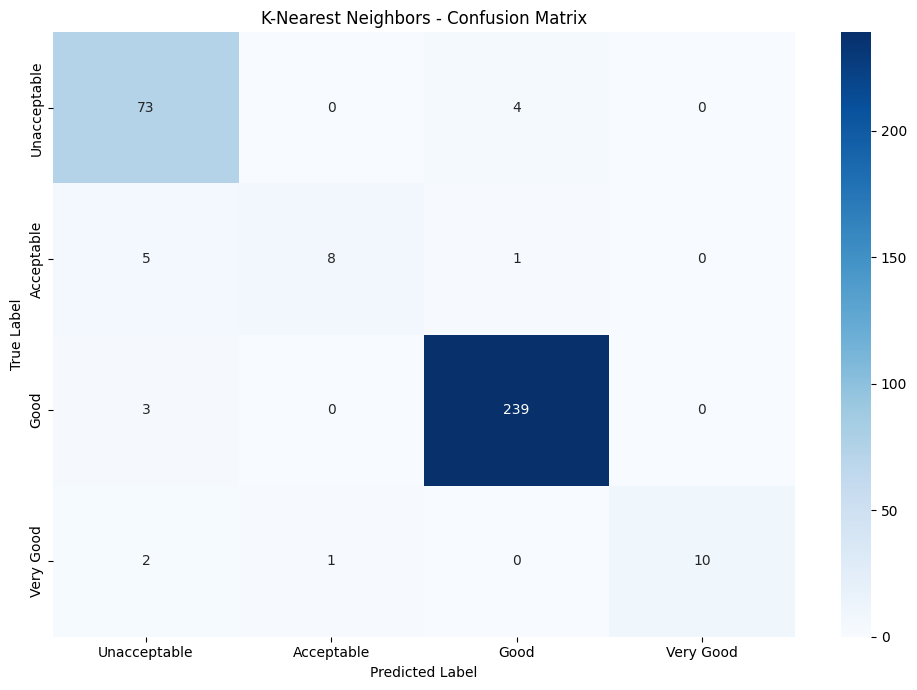

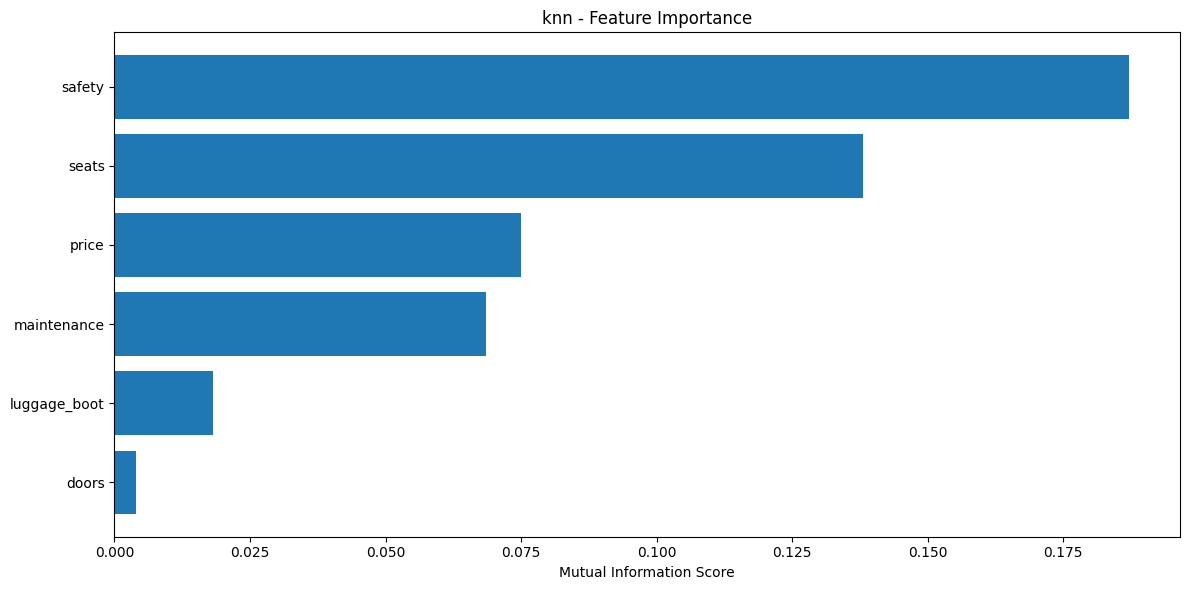

Model saved as Joblib: ..\models\knn\knn_model.joblib
Model saved as Pickle: ..\models\knn\knn_model.pkl


In [271]:
# Train KNN Model
knn_model = KNeighborsClassifier(
    n_neighbors=5,     # Number of neighbors to use
    weights='uniform', # All points in each neighborhood are weighted equally
    n_jobs=-1          # Use all available cores
)

# Measure training time
start_time = time.time()
knn_model.fit(X_train_scaled, y_train)
end_time = time.time()

# Calculate training duration
knn_training_duration = end_time - start_time
print(f"\nTraining Time for Support Vector Classifier: {knn_training_duration:.4f} seconds")

# Evaluate KNN
print("K-Nearest Neighbors Analysis:")
knn_metrics = evaluate_model(knn_model, X_test_scaled, y_test, 'K-Nearest Neighbors')

# Plot KNN Feature Importance
plot_knn_feature_importance(
    X_train_scaled, 
    y_train, 
    feature_names, 
    'knn'
)

save_model(knn_model, "knn")

## Support Vector Classifier

In [272]:
def plot_svc_feature_importance(model, X_train, feature_names, model_name):
    output = "svc feature importance"
    directory = "\\feature_importance\\"
    # For linear SVC, we can use coefficient magnitudes
    if model.kernel == 'linear':
        # Get absolute value of coefficients
        importances = np.abs(model.coef_).mean(axis=0)
        
        plt.figure(figsize=(12,6))
        indices = np.argsort(importances)
        plt.title(f'{model_name} - Feature Importance')
        plt.barh(range(len(indices)), importances[indices])
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Coefficient Magnitude')
        plt.tight_layout()
        plt.show()
        
        return importances
    else:
        # For non-linear kernels, use mutual information
        from sklearn.feature_selection import mutual_info_classif
        
        importances = mutual_info_classif(X_train, model.predict(X_train))
        
        plt.figure(figsize=(12,6))
        indices = np.argsort(importances)
        plt.title(f'{model_name} - Feature Importance')
        plt.barh(range(len(indices)), importances[indices])
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Mutual Information Score')
        plt.tight_layout()
        plt.savefig(graph_directory + directory + output)
        plt.show()
        
        return importances


Training Time for Support Vector Classifier: 0.0180 seconds

Support Vector Classifier Analysis:

Support Vector Classifier Model Performance:
Accuracy: 0.9740
Precision (Macro): 0.9766
Recall (Macro): 0.9513
F1 Score (Macro): 0.9630

Detailed Classification Report:
              precision    recall  f1-score   support

Unacceptable       0.91      0.97      0.94        77
  Acceptable       1.00      0.93      0.96        14
        Good       0.99      0.98      0.99       242
   Very Good       1.00      0.92      0.96        13

    accuracy                           0.97       346
   macro avg       0.98      0.95      0.96       346
weighted avg       0.98      0.97      0.97       346



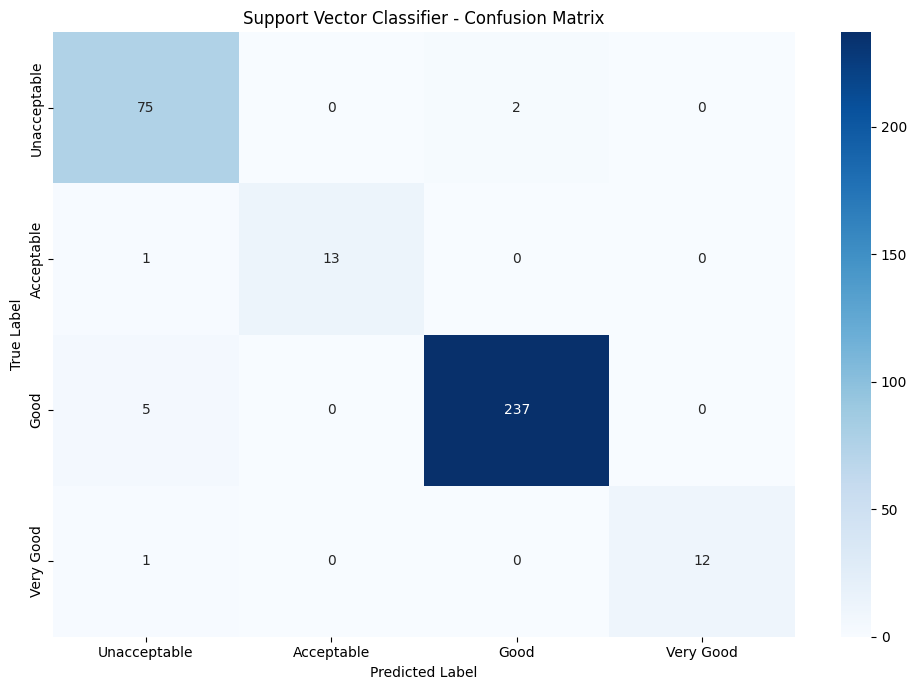

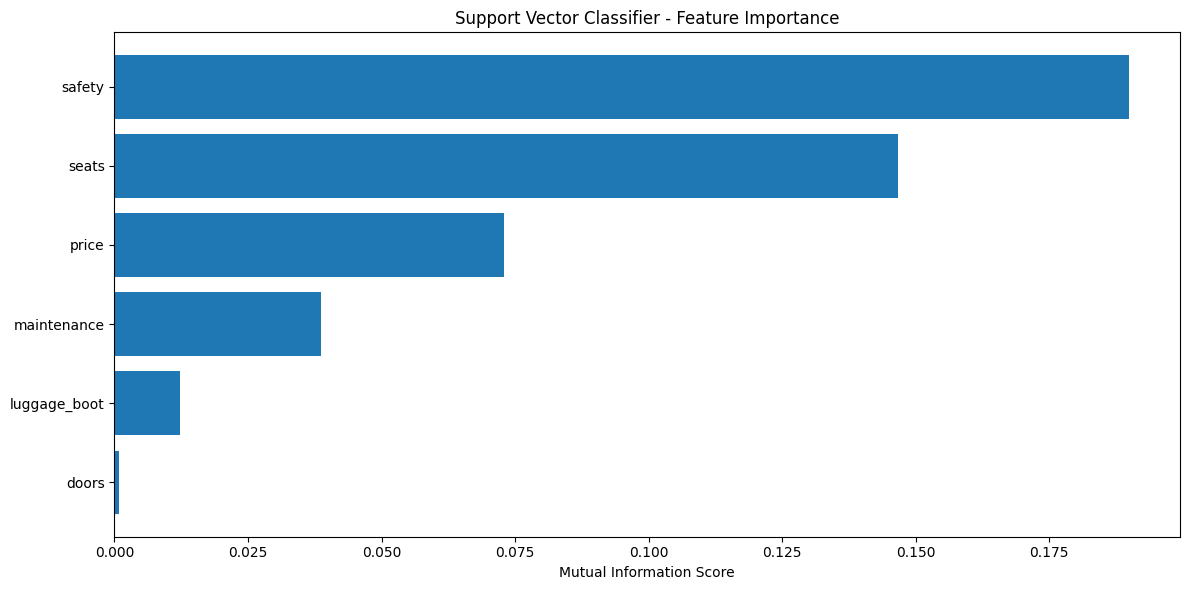

Model saved as Joblib: ..\models\svc\svc_model.joblib
Model saved as Pickle: ..\models\svc\svc_model.pkl


In [273]:
# Train Support Vector Classifier
svc_model = SVC(
    kernel='rbf',        # Radial Basis Function kernel
    C=1.0,               # Regularization parameter
    random_state=42      # For reproducibility
)

# Measure training time
start_time = time.time()
svc_model.fit(X_train_scaled, y_train)
end_time = time.time()

# Calculate training duration
svc_training_duration = end_time - start_time
print(f"\nTraining Time for Support Vector Classifier: {svc_training_duration:.4f} seconds")

# Evaluate Support Vector Classifier
print("\nSupport Vector Classifier Analysis:")
svc_metrics = evaluate_model(svc_model, X_test_scaled, y_test, 'Support Vector Classifier')

# Plot SVC Feature Importance
plot_svc_feature_importance(
    svc_model, 
    X_train_scaled, 
    feature_names, 
    'Support Vector Classifier'
)

save_model(svc_model, "svc")


## Hyperparameter Tuning